## Loading Packages

In [3]:
from ForesightPy import *
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

set_seed(42)

True

## Loading Data

In [5]:
# Custom dataset if desired
# custom_list=["cu_lme", "al_lme"]

path = "../Data/"
universe_dict = universe_select(path, "Cu", custom_list=None)
use_lg_returns = False
use_PCA = True
autoregressive = True

## Preprocessing

In [113]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_only=True, price_only=False)
    target_col = "cu_lme"

else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_only=False, price_only=True)
    target_col = "price_cu_lme"
    
if autoregressive:
    df_full = df_full[[target_col]]

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


### Visualise the dataset

In [114]:
df_full.head(5)
# df_full.tail(5)
# Visualise the plots if desired
# visualise_df(df_full)

,price_cu_lme
date,
2006-09-13,7484.5
2006-09-14,7439.0
2006-09-15,7281.0
2006-09-18,7459.0
2006-09-19,7516.0


### Normalizing the dataset

In [115]:
# Forecast length
# forecast_length = 5
forecast_length = 22
# forecast_length = 66
# forecast_length = 132

# Data scaling
scaler_data_X = MinMaxScaler()

# Transforming the data
data_X = scaler_data_X.fit_transform(df_full)
# Making data 1D
data_X = data_X[:, 0]

print("Data X shape", data_X.shape)

Data X shape (3353,)


In [116]:
def arima_forecaster(history, P, D, Q, forecast_length):
    """Fits an ARIMA model and makes a predicion one
    forecast length into the future
    
    :param history:      The training data the ARIMA model is fit to
    :type  history:      list

    :param P:            The autoregressive parameter for an ARIMA model  
    :type  P:            int  
    
    :param D:            The differencing parameter for an ARIMA model  
    :type  D:            int
    
    :param Q:            The moving average parameter for an ARIMA model  
    :type  Q:            int

    :return:             A predicition one time step into the future
    :rtype:              float
    """
    model = ARIMA(history, order=(P, D, Q))
    model_fit = model.fit(disp=-1)
    prediction = model_fit.forecast(forecast_length)[0]
    return prediction

In [117]:
# Determining the order of the ARIMA parameters
auto = auto_arima(data_X, error_action="ignore")
P, D, Q = auto.order
print("ARIMA Order:", auto.order)

ARIMA Order: (1, 1, 0)


In [118]:
# Training and test dataset
Train = data_X[0:int(len(data_X) * 0.6)]
Test = data_X[int(len(data_X) * 0.6):len(data_X)]

# The rolling window that will grow 
history = [x for x in Train]
# Array to store predictions
predictions = list()

# Rolling Window Predictions
for i in range(len(Test)-forecast_length+1):
    # Making the predictions
    pred = arima_forecaster(history, P, D, Q, forecast_length=forecast_length)[forecast_length-1]
    predictions.append(pred)
    # Keeping constant window size
    history.append(Test[i])
    del(history[0])
        
    if i%100==0: 
        print("Percentage Trained:", 100*i/len(Test))

Percentage Trained: 0.0
Percentage Trained: 7.451564828614009
Percentage Trained: 14.903129657228018
Percentage Trained: 22.35469448584203
Percentage Trained: 29.806259314456035
Percentage Trained: 37.257824143070046
Percentage Trained: 44.70938897168406
Percentage Trained: 52.16095380029806
Percentage Trained: 59.61251862891207
Percentage Trained: 67.06408345752608
Percentage Trained: 74.51564828614009
Percentage Trained: 81.9672131147541
Percentage Trained: 89.41877794336811
Percentage Trained: 96.87034277198211


In [121]:
# Matching the observed and predicted array sizes
observed = Test[forecast_length - 1:]

In [122]:
# Rescaling the results
predictions = np.array(predictions).reshape(len(predictions), 1)
observed  = np.array(observed).reshape(len(observed), 1)

observed_scaled = scaler_data_X.inverse_transform(observed)
predictions_scaled = scaler_data_X.inverse_transform(predictions)

### Plotting Results

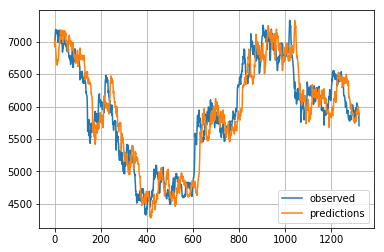

In [123]:
plt.plot(observed_scaled, label='observed')
plt.plot(predictions_scaled, label='predictions')
plt.legend()
plt.grid()
plt.show()

# Results

In [124]:
mse, mae, mda = evaluate(predictions_scaled, observed_scaled, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mda)

Price Metrics:  97652.09555955138 245.06747144651402 0.4643939393939394
